# SegFormer-B2 evaluation on ACDC

This notebook evaluates a trained SegFormer-B2 checkpoint on the ACDC validation split.
It includes:
- environment setup for Colab,
- dataset unpacking,
- checkpoint loading,
- metrics + plots,
- ClearML logging.

In [1]:
!pip install -q segmentation-models-pytorch albumentations torchmetrics pytorch-lightning clearml python-dotenv gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.3 MB/s eta 0:00:00


In [2]:
import os
import zipfile
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import MulticlassJaccardIndex

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from clearml import Task
from google.colab import drive, userdata

In [3]:
CONFIG = {
    "project_name": "Segmentation_Urban_Scene_CourseWork",
    "task_name": "SegFormer_B2_Eval_ACDC_Val",
    "drive_root": "/content/drive/MyDrive",
    "weights_rel_path": "weights/segformer-b2-cityscapes-epoch=43-val_miou=0.73.ckpt",
    "acdc_zips": [
        "gt_trainval.zip",
        "rgb_anon_trainvaltest.zip",
    ],
    "data_dir": "/content/data/acdc",
    "split": "val",
    "conditions": ["fog", "night", "rain", "snow"],
    "encoder": "mit_b2",
    "encoder_weights": "imagenet",
    "num_classes": 19,
    "image_size": (512, 1024),
    "batch_size": 8,
    "num_workers": 2,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light",
    "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car",
    "truck", "bus", "train", "motorcycle", "bicycle"
]

os.environ["CLEARML_API_ACCESS_KEY"] = userdata.get("CLEARML_API_ACCESS_KEY")
os.environ["CLEARML_API_SECRET_KEY"] = userdata.get("CLEARML_API_SECRET_KEY")

task = Task.init(
    project_name=CONFIG["project_name"],
    task_name=CONFIG["task_name"],
    output_uri=False,
)
task.connect(CONFIG)

print(f"Using device: {CONFIG['device']}")

ClearML Task: created new task id=0681c728bbf440e5b72a0fdb70d2a2a2


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


ClearML results page: https://app.clear.ml/projects/588d5d925230490b9f98b1007b4c7fa0/experiments/0681c728bbf440e5b72a0fdb70d2a2a2/output/log
Using device: cuda


In [4]:
drive.mount("/content/drive")

Path(CONFIG["data_dir"]).mkdir(parents=True, exist_ok=True)

for zip_name in CONFIG["acdc_zips"]:
    zip_path = Path(CONFIG["drive_root"]) / zip_name
    if not zip_path.exists():
        raise FileNotFoundError(f"Zip file not found: {zip_path}")

    print(f"Unpacking {zip_path} -> {CONFIG['data_dir']}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(CONFIG["data_dir"])

weights_path = Path(CONFIG["drive_root"]) / CONFIG["weights_rel_path"]
if not weights_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {weights_path}")

print(f"Checkpoint path: {weights_path}")

Mounted at /content/drive
Unpacking /content/drive/MyDrive/gt_trainval.zip -> /content/data/acdc
Unpacking /content/drive/MyDrive/rgb_anon_trainvaltest.zip -> /content/data/acdc
Checkpoint path: /content/drive/MyDrive/weights/segformer-b2-cityscapes-epoch=43-val_miou=0.73.ckpt


In [5]:
def _to_float32(image, **kwargs):
    return image.astype(np.float32)


class ACDCDataset(Dataset):
    def __init__(self, root_dir, split="val", conditions=None, preprocessing=None, resize_hw=(512, 1024)):
        self.root_dir = Path(root_dir)
        self.split = split
        self.conditions = conditions or ["fog", "night", "rain", "snow"]
        self.preprocessing = preprocessing
        self.resize = A.Compose([A.Resize(height=resize_hw[0], width=resize_hw[1])])
        self.items = []

        for condition in self.conditions:
            rgb_root = self.root_dir / "rgb_anon" / condition / split
            gt_root = self.root_dir / "gt" / condition / split
            if not rgb_root.exists() or not gt_root.exists():
                print(f"Skip missing split folder: {condition}/{split}")
                continue

            for image_path in sorted(rgb_root.rglob("*_rgb_anon.png")):
                rel = image_path.relative_to(rgb_root)
                mask_name = image_path.name.replace("_rgb_anon.png", "_gt_labelTrainIds.png")
                mask_path = gt_root / rel.parent / mask_name
                if mask_path.exists():
                    self.items.append(
                        {
                            "image": str(image_path),
                            "mask": str(mask_path),
                            "condition": condition,
                            "stem": image_path.stem,
                        }
                    )

        if len(self.items) == 0:
            raise RuntimeError("No ACDC image/mask pairs found. Check dataset path and split.")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        sample = self.items[idx]
        image = cv2.imread(sample["image"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(sample["mask"], 0)

        transformed = self.resize(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"]

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        return {
            "image": image,
            "mask": mask.long(),
            "condition": sample["condition"],
            "stem": sample["stem"],
        }

In [6]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(CONFIG["encoder"], CONFIG["encoder_weights"])

preprocessing = A.Compose([
    A.Lambda(image=preprocessing_fn),
    A.Lambda(image=_to_float32),
    ToTensorV2(),
])

dataset = ACDCDataset(
    root_dir=CONFIG["data_dir"],
    split=CONFIG["split"],
    conditions=CONFIG["conditions"],
    preprocessing=preprocessing,
    resize_hw=CONFIG["image_size"],
)

loader = DataLoader(
    dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
    pin_memory=True,
)

print(f"ACDC samples: {len(dataset)}")
print(pd.DataFrame(dataset.items)["condition"].value_counts().sort_index())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning:


Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).



config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

ACDC samples: 406
condition
fog      100
night    106
rain     100
snow     100
Name: count, dtype: int64


In [7]:
def build_model(num_classes=19):
    model = smp.Segformer(
        encoder_name=CONFIG["encoder"],
        encoder_weights=CONFIG["encoder_weights"],
        in_channels=3,
        classes=num_classes,
    )
    return model


def load_lightning_checkpoint_to_smp_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt.get("state_dict", ckpt)

    model_state = {}
    for key, value in state_dict.items():
        if key.startswith("model."):
            model_state[key[len("model."):]] = value

    missing, unexpected = model.load_state_dict(model_state, strict=False)
    print(f"Missing keys: {len(missing)}")
    print(f"Unexpected keys: {len(unexpected)}")

    model.to(device)
    model.eval()
    return model


model = build_model(num_classes=CONFIG["num_classes"])
model = load_lightning_checkpoint_to_smp_model(model, str(weights_path), CONFIG["device"])

model.safetensors:   0%|          | 0.00/98.9M [00:00<?, ?B/s]

Missing keys: 0
Unexpected keys: 0


In [8]:
@torch.no_grad()
def evaluate(model, dataloader, num_classes=19, device="cpu"):
    metric_all = MulticlassJaccardIndex(num_classes=num_classes, average="macro", ignore_index=255).to(device)
    metric_per_class = MulticlassJaccardIndex(num_classes=num_classes, average="none", ignore_index=255).to(device)

    condition_metrics = {
        cond: MulticlassJaccardIndex(num_classes=num_classes, average="macro", ignore_index=255).to(device)
        for cond in CONFIG["conditions"]
    }

    total_pixels = 0
    total_correct = 0

    cache = []

    for batch in dataloader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)
        conditions = batch["condition"]

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        metric_all.update(preds, masks)
        metric_per_class.update(preds, masks)

        valid = masks != 255
        total_correct += ((preds == masks) & valid).sum().item()
        total_pixels += valid.sum().item()

        for i, cond in enumerate(conditions):
            condition_metrics[cond].update(preds[i:i+1], masks[i:i+1])

        cache.append(
            {
                "images": images.detach().cpu(),
                "masks": masks.detach().cpu(),
                "preds": preds.detach().cpu(),
                "conditions": list(conditions),
                "stems": list(batch["stem"]),
            }
        )

    overall_miou = metric_all.compute().item()
    class_iou = metric_per_class.compute().detach().cpu().numpy()
    pixel_acc = total_correct / max(total_pixels, 1)

    condition_miou = {
        cond: metric.compute().item()
        for cond, metric in condition_metrics.items()
    }

    return {
        "overall_miou": overall_miou,
        "pixel_accuracy": pixel_acc,
        "class_iou": class_iou,
        "condition_miou": condition_miou,
        "cache": cache,
    }


results = evaluate(model, loader, num_classes=CONFIG["num_classes"], device=CONFIG["device"])

In [9]:
summary_df = pd.DataFrame(
    {
        "metric": ["mIoU", "Pixel Accuracy"],
        "value": [results["overall_miou"], results["pixel_accuracy"]],
    }
)

condition_df = pd.DataFrame(
    {
        "condition": list(results["condition_miou"].keys()),
        "mIoU": list(results["condition_miou"].values()),
    }
).sort_values("condition")

class_df = pd.DataFrame(
    {
        "class_id": list(range(CONFIG["num_classes"])),
        "class_name": CITYSCAPES_CLASSES,
        "IoU": results["class_iou"],
    }
).sort_values("IoU", ascending=False)

print("Overall metrics")
display(summary_df)
print("\nPer-condition mIoU")
display(condition_df)
print("\nPer-class IoU")
display(class_df)

logger = task.get_logger()
logger.report_table("evaluation", "overall", iteration=0, table_plot=summary_df)
logger.report_table("evaluation", "per_condition", iteration=0, table_plot=condition_df)
logger.report_table("evaluation", "per_class", iteration=0, table_plot=class_df)
logger.report_scalar("evaluation", "mIoU", results["overall_miou"], iteration=0)
logger.report_scalar("evaluation", "pixel_accuracy", results["pixel_accuracy"], iteration=0)

Overall metrics


,metric,value
0,mIoU,0.446281
1,Pixel Accuracy,0.768507



Per-condition mIoU


,condition,mIoU
0,fog,0.582002
1,night,0.246120
2,rain,0.472170
3,snow,0.455311



Per-class IoU


,class_id,class_name,IoU
8,8,vegetation,0.756335
13,13,car,0.724211
2,2,building,0.648396
0,0,road,0.630733
10,10,sky,0.614267
6,6,traffic light,0.533262
14,14,truck,0.473401
11,11,person,0.469279
15,15,bus,0.454176
16,16,train,0.446816


/usr/local/lib/python3.12/dist-packages/clearml/utilities/plotlympl/renderer.py:209: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



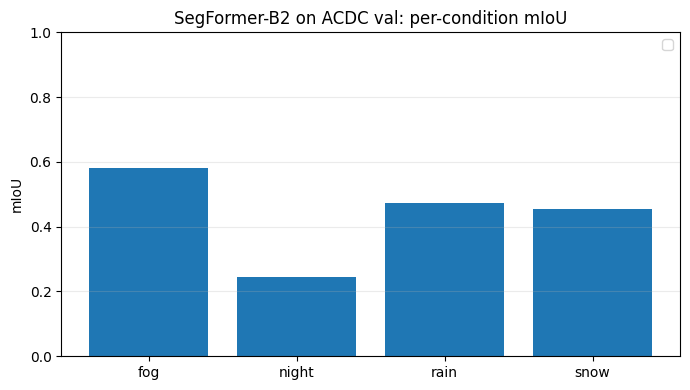

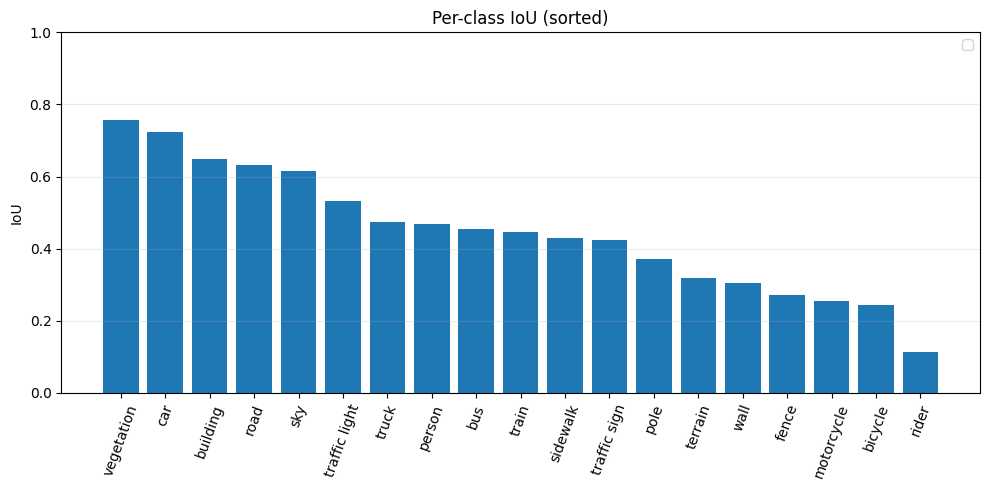

In [10]:
fig1, ax1 = plt.subplots(figsize=(7, 4))
ax1.bar(condition_df["condition"], condition_df["mIoU"])
ax1.set_ylim(0, 1)
ax1.set_ylabel("mIoU")
ax1.set_title("SegFormer-B2 on ACDC val: per-condition mIoU")
ax1.grid(axis="y", alpha=0.25)
fig1.tight_layout()
plt.show()

logger.report_matplotlib_figure(
    title="plots",
    series="per_condition_miou",
    iteration=0,
    figure=fig1,
)

plot_df = class_df.sort_values("IoU", ascending=False)
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.bar(plot_df["class_name"], plot_df["IoU"])
ax2.set_ylim(0, 1)
ax2.set_ylabel("IoU")
ax2.set_title("Per-class IoU (sorted)")
ax2.grid(axis="y", alpha=0.25)
ax2.tick_params(axis="x", rotation=70)
fig2.tight_layout()
plt.show()

logger.report_matplotlib_figure(
    title="plots",
    series="per_class_iou",
    iteration=0,
    figure=fig2,
)

In [11]:
def denormalize_for_display(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy().astype(np.float32)
    # Fast visual fallback: min-max after encoder preprocessing.
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img


def _collect_condition_samples_from_cache(cached_batches, conditions, samples_per_condition=3):
    collected = {cond: [] for cond in conditions}
    for batch in cached_batches:
        for i, cond in enumerate(batch["conditions"]):
            if cond in collected and len(collected[cond]) < samples_per_condition:
                collected[cond].append(
                    {
                        "image": batch["images"][i],
                        "mask": batch["masks"][i],
                        "pred": batch["preds"][i],
                    }
                )
        if all(len(collected[c]) >= samples_per_condition for c in conditions):
            break
    return collected


def show_predictions_by_condition(cached_batches, condition_miou, conditions, samples_per_condition=3):
    samples = _collect_condition_samples_from_cache(cached_batches, conditions, samples_per_condition)

    rows = len(conditions) * samples_per_condition
    fig, axes = plt.subplots(rows, 3, figsize=(14, rows * 3.2))
    if rows == 1:
        axes = np.array([axes])

    row_idx = 0
    for cond in conditions:
        cond_score = condition_miou.get(cond, float("nan"))
        for s_idx in range(samples_per_condition):
            if s_idx < len(samples[cond]):
                sample = samples[cond][s_idx]
                image = denormalize_for_display(sample["image"])
                gt = sample["mask"].numpy()
                pred = sample["pred"].numpy()

                axes[row_idx, 0].imshow(image)
                axes[row_idx, 0].set_title(f"{cond} #{s_idx + 1} | image")
                axes[row_idx, 0].axis("off")

                axes[row_idx, 1].imshow(gt, vmin=0, vmax=18)
                axes[row_idx, 1].set_title(f"GT | {cond} mIoU={cond_score:.4f}")
                axes[row_idx, 1].axis("off")

                axes[row_idx, 2].imshow(pred, vmin=0, vmax=18)
                axes[row_idx, 2].set_title("Prediction")
                axes[row_idx, 2].axis("off")
            else:
                axes[row_idx, 0].axis("off")
                axes[row_idx, 1].axis("off")
                axes[row_idx, 2].axis("off")
            row_idx += 1

    fig.tight_layout()
    plt.show()
    return fig


def _predict_ref_single_image(image_path, model, preprocessing, resize_hw, device):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    resized = A.Resize(height=resize_hw[0], width=resize_hw[1])(image=image)
    image_resized = resized["image"]

    prep_out = preprocessing(image=image_resized)
    image_tensor = prep_out["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image_tensor)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()
        max_prob = probs.max(dim=1).values.squeeze(0).cpu().numpy()

    mean_conf = float(max_prob.mean())
    entropy = float((-probs * torch.log(probs + 1e-8)).sum(dim=1).mean().item())

    return {
        "image": image_resized,
        "pred": pred,
        "mean_conf": mean_conf,
        "mean_entropy": entropy,
    }


def show_ref_predictions_by_condition(root_dir, split_ref, conditions, model, preprocessing, resize_hw, device, samples_per_condition=3):
    collected = {cond: [] for cond in conditions}

    for cond in conditions:
        ref_root = Path(root_dir) / "rgb_anon" / cond / split_ref
        if not ref_root.exists():
            continue

        files = sorted(ref_root.rglob("*_rgb_ref_anon.png"))
        for fp in files[:samples_per_condition]:
            pred_item = _predict_ref_single_image(
                image_path=fp,
                model=model,
                preprocessing=preprocessing,
                resize_hw=resize_hw,
                device=device,
            )
            collected[cond].append(pred_item)

    rows = len(conditions) * samples_per_condition
    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 3.2))
    if rows == 1:
        axes = np.array([axes])

    row_idx = 0
    metrics_rows = []
    for cond in conditions:
        conf_vals = []
        ent_vals = []
        for s_idx in range(samples_per_condition):
            if s_idx < len(collected[cond]):
                item = collected[cond][s_idx]
                conf_vals.append(item["mean_conf"])
                ent_vals.append(item["mean_entropy"])

                axes[row_idx, 0].imshow(item["image"])
                axes[row_idx, 0].set_title(f"{cond} ref #{s_idx + 1} | image")
                axes[row_idx, 0].axis("off")

                axes[row_idx, 1].imshow(item["pred"], vmin=0, vmax=18)
                axes[row_idx, 1].set_title(
                    f"Prediction | conf={item['mean_conf']:.3f}, H={item['mean_entropy']:.3f}"
                )
                axes[row_idx, 1].axis("off")
            else:
                axes[row_idx, 0].axis("off")
                axes[row_idx, 1].axis("off")
            row_idx += 1

        if len(conf_vals) > 0:
            metrics_rows.append(
                {
                    "condition": cond,
                    "mean_confidence": float(np.mean(conf_vals)),
                    "mean_entropy": float(np.mean(ent_vals)),
                    "num_samples": len(conf_vals),
                }
            )

    fig.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame(metrics_rows)
    return fig, metrics_df


fig3 = show_predictions_by_condition(
    cached_batches=results["cache"],
    condition_miou=results["condition_miou"],
    conditions=CONFIG["conditions"],
    samples_per_condition=3,
)
logger.report_matplotlib_figure(
    title="plots",
    series="qualitative_predictions_by_condition",
    iteration=0,
    figure=fig3,
)

fig4, ref_metrics_df = show_ref_predictions_by_condition(
    root_dir=CONFIG["data_dir"],
    split_ref=f"{CONFIG['split']}_ref",
    conditions=CONFIG["conditions"],
    model=model,
    preprocessing=preprocessing,
    resize_hw=CONFIG["image_size"],
    device=CONFIG["device"],
    samples_per_condition=3,
)
logger.report_matplotlib_figure(
    title="plots",
    series="qualitative_predictions_ref_by_condition",
    iteration=0,
    figure=fig4,
)

if len(ref_metrics_df) > 0:
    print("Ref split proxy metrics (no GT-based IoU):")
    display(ref_metrics_df)
    logger.report_table("evaluation", "ref_proxy_metrics", iteration=0, table_plot=ref_metrics_df)
    for _, row in ref_metrics_df.iterrows():
        logger.report_scalar("ref_proxy", f"confidence_{row['condition']}", row["mean_confidence"], iteration=0)
        logger.report_scalar("ref_proxy", f"entropy_{row['condition']}", row["mean_entropy"], iteration=0)
else:
    print("No ref images found for selected split.")

Output hidden; open in https://colab.research.google.com to view.

In [12]:
task.close()
print("ClearML task closed.")

█████████████████████████████████ 100% | 7.52/7.52 MB [00:00<00:00, 14.48MB/s]: 
█████████████████████████████████ 100% | 7.52/7.52 MB [00:00<00:00, 14.43MB/s]: 


ClearML task closed.
